In [1]:
#%%
import pandas as pd
from pathlib import Path
import numpy as np 
import sys
import altair as alt
import chart_theme

# register the custom theme under a chosen name
alt.themes.register('la-times', chart_theme.data_theme)

# enable the newly registered theme
alt.themes.enable('la-times')


ThemeRegistry.enable('la-times')

In [2]:




file2013 = pd.read_csv("data/2013_SSP_ACO_PUF/Final.ACO.SSP.PUF.Y2013_with_risk_scores.csv")
file2014 = pd.read_csv("data/2014_SSP_ACO_PUF/ACO.SSP.PUF.Y2014.FINAL.csv")
file2015 = pd.read_csv("data/2015_SSP_ACO_PUF/ACO.SSP.PUF.Y2015.csv")
file2016 = pd.read_csv("data/2016_SSP_ACO_PUF/ACO.SSP.PUF.Y2016.csv")
file2017 = pd.read_csv("data/2017_SSP_ACO_PUF/ACO.SSP.PUF.Y2017.csv")


#%%
file2013['year'] = 2013
file2013['EarnSaveLoss'] = file2013.EarnShrSavings
file2013['ACO_Name'] = file2013.ACO_NAME

file2014['year'] = 2014
file2015['year'] = 2015
file2016['year'] = 2016
file2017['year'] = 2017

interesting_columns = ['year','ACO_Name','EarnSaveLoss','N_AB','CMS_HCC_RiskScore_AGND_PY']
all_frames = [file2013, file2014, file2015,file2016, file2017]
combined_frame = pd.concat([frame[interesting_columns] for frame in all_frames])


#%%
def de_comma_number(num):
    num_str = str(num)
    try:
        float(num_str.replace(",",""))
    except:
        return 0
    return float(num_str.replace(",",""))


def earning(save_loss):
    if type(save_loss) == str:
        num_val = de_comma_number(save_loss)
    else:
        num_val = save_loss
    
    if num_val > 0:
        return "Earned"
    else:
        return "No Earnings"

combined_frame['Earning'] = combined_frame.EarnSaveLoss.apply(earning)
combined_frame['members'] = combined_frame.N_AB.apply(de_comma_number)
print(combined_frame.columns)


Index(['year', 'ACO_Name', 'EarnSaveLoss', 'N_AB', 'CMS_HCC_RiskScore_AGND_PY',
       'Earning', 'members'],
      dtype='object')


In [3]:

def weighted_average_group(group):
    total = group['members'].sum()
    aco_values = group['CMS_HCC_RiskScore_AGND_PY'] * group['members']
    result =  aco_values.sum()/total
    # result.name = 'RiskScoreAvgWGHT'
    return result

aggregate_results = combined_frame.groupby(['year','Earning']).agg({'ACO_Name':np.count_nonzero, 'members':np.sum })

wght_averages = combined_frame.groupby(['year','Earning']).apply(weighted_average_group)
wght_averages.name = 'ACO_WGHT_HCC_AVG'
data_to_chart = aggregate_results.join(wght_averages).reset_index()

In [4]:
data_to_chart

,year,Earning,ACO_Name,members,ACO_WGHT_HCC_AVG
0,2013,Earned,52,886810.0,1.086600
1,2013,No Earnings,168,2788453.0,1.048451
2,2014,Earned,86,1354279.0,1.078080
3,2014,No Earnings,247,3975552.0,1.047277
4,2015,Earned,119,2074841.0,1.080939
5,2015,No Earnings,273,5195392.0,1.039918
6,2016,Earned,134,2169026.0,1.099063
7,2016,No Earnings,298,5715032.0,1.057009
8,2017,Earned,159,2963991.0,1.015513
9,2017,No Earnings,313,6028895.0,0.997226


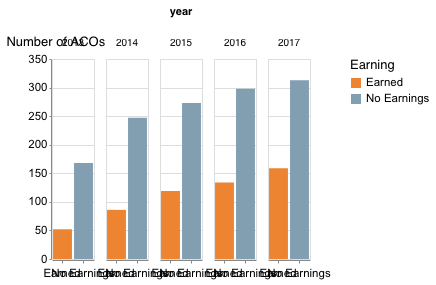

In [5]:
alt.Chart(data_to_chart).mark_bar().encode(
    x=alt.X('Earning:N',axis=alt.Axis(title='')),
    y=alt.Y('ACO_Name:Q', axis=alt.Axis(title='Number of ACOs')),
    color='Earning:N',
    column='year:O'
)

